In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize

plt.style.use('seaborn')
%matplotlib inline

## Compra

In [2]:
compra = pd.read_csv('data/1_Orden_compra.csv', sep=';')
compra.head()

,order_id,lat,lng,dow,promised_time,actual_time,on_demand,picker_id,driver_id,store_branch_id,total_minutes
0,6abd5e28d01b7c733fe37485294235dc,1.822.114.109.606.680,-10.031.391.366.664.600,2,13:00:00,12:00:15,False,09bb5bfe76adbb474dddbdd111a51623,09bb5bfe76adbb474dddbdd111a51623,0dc6fb5924a8b917bc641666ed02663c,91.800.861
1,0d37a1eea001f01b40232ffd496ff663,18.177.712.202.580.300,-10.035.705.073.096.900,2,13:00:00,10:28:10,False,c4c722114a82fa21654e57e9636d68b0,c4c722114a82fa21654e57e9636d68b0,2bbf833e689d24b697f1f3529c3f3c4b,206.599.732
2,528428e9b9eb5d3bd0dbdd8da692b087,1.826.683.205.404.410,-10.031.755.280.890.600,2,11:00:00,10:40:50,False,e15c7a67d0ea9a54dffb410bc1d8528b,e15c7a67d0ea9a54dffb410bc1d8528b,8d891dfc0e29d744c15c18adced74a68,93.458.001
3,d3f7be6d64eae7405b7bf024e04807a2,18.248.884.004.419.400,-1.003.226.215.187.040,2,10:00:00,9:41:47,False,d1f0bd4b237c1358f09db22076b940e7,d1f0bd4b237c1358f09db22076b940e7,0dc6fb5924a8b917bc641666ed02663c,124.778.761
4,e0ad6533b6cd9a382ec6c1d473c5036c,1.822.911.027.242.010,-10.032.267.241.783.800,2,11:00:00,10:07:53,False,06a71e8ab0c6db5ce22a4689fd76a3f4,06a71e8ab0c6db5ce22a4689fd76a3f4,afd0a7b8d546fcc697bb93a5934b65c3,130.321.208


In [3]:
compra['on_demand'].value_counts()

False    4225
True     3070
Name: on_demand, dtype: int64

In [4]:
#Se recodifica el atributo Booleano
compra['on_demand'] = np.where(compra['on_demand'] == False, 1, 0)

In [5]:
compra['on_demand'].value_counts()

1    4225
0    3070
Name: on_demand, dtype: int64

In [6]:
compra.shape

(7295, 11)

## Productos

In [7]:
productos = pd.read_csv('data/2_Orden_productos.csv', sep=';')
productos.head()

,order_id,product_id,quantity,quantity_found,buy_unit
0,bdfc44fb525986b7bab8c589fc47e853,ab9757d9892b0e83ab3a1c1af0c84c52,0.75,0.155,KG
1,bdfc44fb525986b7bab8c589fc47e853,f1f042251bf634d44f338fbaf13b16e4,0.3,0.400,KG
2,bdfc44fb525986b7bab8c589fc47e853,0630d47440965509b0b3f80fd1b3578f,1,1.000,UN
3,bdfc44fb525986b7bab8c589fc47e853,9dd69b1f300666d5573e3a9934f2e03e,2,2.000,UN
4,bdfc44fb525986b7bab8c589fc47e853,3dfcdbe308bde67370649dd875f2507b,1,1.000,UN


Aquellos productos que se pesan, se contabilizan como 1. Además se remueven outliers y se transforma todo a numerico

In [8]:
productos['cantidad_aj'] = np.where(productos['buy_unit'] == 'KG' , 1, productos['quantity'])
productos['cantidad_aj'] = pd.to_numeric(productos['cantidad_aj'])

In [9]:
no_KG = productos.loc[(productos['cantidad_aj'] == 0.225) | (productos['cantidad_aj'] == 0.090)]
no_KG.head()

,order_id,product_id,quantity,quantity_found,buy_unit,cantidad_aj
29253,7a1be969ec97b66b710f7dc5b80f8a6f,068566a7b65d4093075f13ae383aa3d4,0.09,0.090,UN,0.090
96244,a5fc3ba3db31ac6a1ea5ddb87dcbc596,e0922ceeaeb05c556c27138d10305932,0.225,0.225,UN,0.225


Existen par de productos que en la __unidad de compra__ marcan como __"UN"__ cuando en realidad son de tipo __"KG"__.

In [10]:
#Se reemplazan esos valores
productos.loc[29253, 'buy_unit'] = 'KG'
productos.loc[96244, 'buy_unit'] = 'KG'

In [11]:
#Se actualizan los datos
productos['cantidad_aj'] = np.where(productos['buy_unit'] == 'KG' , 1, productos['quantity'])
productos['cantidad_aj'] = pd.to_numeric(productos['cantidad_aj'])

In [12]:
#productos['cantidad_aj'] = np.where(np.isnan(productos['cantidad_aj']), np.nan, productos['cantidad_aj'])
productos['cantidad_aj'] = np.where(productos['cantidad_aj'] > 120, 'outlier', productos['cantidad_aj'])

No se encontraron Outliers.

Se separa entre tipo de productos: Aquellos que se pesan y aquellos que no, además de poner la cantidad total

In [13]:
tipo = pd.get_dummies(productos['buy_unit'])

In [14]:
productos['sin_pesar'] = tipo['UN']
productos['pesados'] = tipo ['KG']
productos['cantidad_total'] = productos['sin_pesar'] + productos['pesados']
productos.drop(columns=['quantity', 'quantity_found', 'buy_unit', 'product_id', 'cantidad_aj'], inplace=True)

In [15]:
productos_agrupados = productos.groupby(by='order_id').sum().reset_index()

In [16]:
productos_agrupados.head()

,order_id,sin_pesar,pesados,cantidad_total
0,001ef94c50c71cb0e674b6293e9b6068,30,5,35
1,001f7583bb106a338d09a12a89e54cbd,5,0,5
2,002b6dcb32fef90ebb1cb691afe6a413,9,0,9
3,002ebc46f3e40c49044aceb8311df432,3,1,4
4,002f97bd7dad0d275d8511436c18b572,7,4,11


## Recolector

In [17]:
recolector = pd.read_csv('data/3_Recolector.csv', sep=';')
recolector.head()

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,087ab65ceca40dbef697f585dc159d5d,ADVANCED,0.8610,1.64,1.00,4.48
1,645973c41314d763b58dc2bceeeeffc9,INTERMEDIATE,0.8337,2.83,0.96,4.79
2,82810715fdda44962e7e422015ea1f32,ADVANCED,0.8681,1.27,0.88,4.84
3,416aa7dbd5a2f58d7bca96657e8faa1e,INTERMEDIATE,0.8784,2.11,1.00,NaN
4,27a3e845a4c3eb7ded4748f84140a843,ADVANCED,0.8466,1.50,1.00,4.84


In [18]:
recolector.shape

(600, 6)

In [19]:
recolector['seniority'].value_counts()

ADVANCED        268
INTERMEDIATE    204
REVIEW           99
BEGINNER         29
Name: seniority, dtype: int64

In [20]:
recolector = pd.get_dummies(recolector, columns=['seniority'], prefix='seniority', prefix_sep='_')

In [21]:
recolector.head()

,shopper_id,found_rate,picking_speed,accepted_rate,rating,seniority_ADVANCED,seniority_BEGINNER,seniority_INTERMEDIATE,seniority_REVIEW
0,087ab65ceca40dbef697f585dc159d5d,0.8610,1.64,1.00,4.48,1,0,0,0
1,645973c41314d763b58dc2bceeeeffc9,0.8337,2.83,0.96,4.79,0,0,1,0
2,82810715fdda44962e7e422015ea1f32,0.8681,1.27,0.88,4.84,1,0,0,0
3,416aa7dbd5a2f58d7bca96657e8faa1e,0.8784,2.11,1.00,NaN,0,0,1,0
4,27a3e845a4c3eb7ded4748f84140a843,0.8466,1.50,1.00,4.84,1,0,0,0


## Tiendas

In [22]:
tienda = pd.read_csv('data/4_tienda.csv', sep=';')
tienda.head()

,store_branch_id,store,lat,lng
0,cf0895f1e3beb8164f0a86e6f940ae56,c0b93cf93cf854981b8d6bd849eec4b0,18.160.308.413.602.800,-10.026.067.265.111.100
1,3ddd4c29cab4178d89d549c6ba65c236,044d56734d20e04984d846dade6d39f3,1.827.282.968.914.450,-10.031.881.435.593.900
2,e9763f24fd46d0b9e52d423207a87c3c,452ae015bf846e1d2932b7ea15720d64,18.273.494.015.704.800,-10.031.958.539.978.200
3,49b7d60d6095a9f1129ce798102b62f4,6447951cd071f6f045fd4e6194920926,1.824.774.341.566.610,-10.040.355.771.938.600
4,8f21cfda17b340aeee062220d0bee8e5,452ae015bf846e1d2932b7ea15720d64,18.203.111.495.565.700,-10.029.771.361.550.100


In [23]:
tienda.shape

(113, 4)

## Consolidacion

In [24]:
#Consolidación de los df compra y prodructos
df = pd.merge(compra, productos_agrupados, how='left', on='order_id')

In [25]:
#se cambia el nombre de la columna del df recolector
recolector.rename(columns={'shopper_id':'picker_id'}, inplace=True)
#Consolidación del df con recolector
df = pd.merge(df, recolector, how='left', on='picker_id')

In [26]:
#consolidación de todos los dataset
df = pd.merge(df, tienda, how='left', on='store_branch_id')

In [27]:
df.shape

(7295, 25)

In [28]:
df.to_csv('data/consolidado.csv', header=True, index=False)

In [29]:
df.head()

,order_id,lat_x,lng_x,dow,promised_time,actual_time,on_demand,picker_id,driver_id,store_branch_id,...,picking_speed,accepted_rate,rating,seniority_ADVANCED,seniority_BEGINNER,seniority_INTERMEDIATE,seniority_REVIEW,store,lat_y,lng_y
0,6abd5e28d01b7c733fe37485294235dc,1.822.114.109.606.680,-10.031.391.366.664.600,2,13:00:00,12:00:15,1,09bb5bfe76adbb474dddbdd111a51623,09bb5bfe76adbb474dddbdd111a51623,0dc6fb5924a8b917bc641666ed02663c,...,1.56,1.00,4.68,1,0,0,0,60e4c4e1c1a8bc79123738227b9d0b08,1.823.190.132.492.320,-1.003.035.533.737.440
1,0d37a1eea001f01b40232ffd496ff663,18.177.712.202.580.300,-10.035.705.073.096.900,2,13:00:00,10:28:10,1,c4c722114a82fa21654e57e9636d68b0,c4c722114a82fa21654e57e9636d68b0,2bbf833e689d24b697f1f3529c3f3c4b,...,1.14,1.00,4.76,1,0,0,0,387d4a5b65cf4bf00ad805c4b00eed01,18.163.960.871.027.900,-10.032.899.405.911.000
2,528428e9b9eb5d3bd0dbdd8da692b087,1.826.683.205.404.410,-10.031.755.280.890.600,2,11:00:00,10:40:50,1,e15c7a67d0ea9a54dffb410bc1d8528b,e15c7a67d0ea9a54dffb410bc1d8528b,8d891dfc0e29d744c15c18adced74a68,...,2.03,1.00,4.96,0,0,1,0,0fae7b61265bc7ca4ce4d81440b62501,1.824.565.541.228.880,-1.003.324.934.760.470
3,d3f7be6d64eae7405b7bf024e04807a2,18.248.884.004.419.400,-1.003.226.215.187.040,2,10:00:00,9:41:47,1,d1f0bd4b237c1358f09db22076b940e7,d1f0bd4b237c1358f09db22076b940e7,0dc6fb5924a8b917bc641666ed02663c,...,2.06,0.92,4.92,0,0,1,0,60e4c4e1c1a8bc79123738227b9d0b08,1.823.190.132.492.320,-1.003.035.533.737.440
4,e0ad6533b6cd9a382ec6c1d473c5036c,1.822.911.027.242.010,-10.032.267.241.783.800,2,11:00:00,10:07:53,1,06a71e8ab0c6db5ce22a4689fd76a3f4,06a71e8ab0c6db5ce22a4689fd76a3f4,afd0a7b8d546fcc697bb93a5934b65c3,...,1.89,1.00,4.92,1,0,0,0,452ae015bf846e1d2932b7ea15720d64,1.823.159.108.764.060,-10.031.450.001.698.800


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7295 entries, 0 to 7294
Data columns (total 25 columns):
order_id                  7295 non-null object
lat_x                     7295 non-null object
lng_x                     7295 non-null object
dow                       7295 non-null int64
promised_time             7295 non-null object
actual_time               7295 non-null object
on_demand                 7295 non-null int32
picker_id                 7295 non-null object
driver_id                 7295 non-null object
store_branch_id           7295 non-null object
total_minutes             6543 non-null object
sin_pesar                 7278 non-null float64
pesados                   7278 non-null float64
cantidad_total            7278 non-null float64
found_rate                7212 non-null float64
picking_speed             7295 non-null float64
accepted_rate             7289 non-null float64
rating                    7218 non-null float64
seniority_ADVANCED        7295 non-null ui

In [31]:
df.isnull().any()

order_id                  False
lat_x                     False
lng_x                     False
dow                       False
promised_time             False
actual_time               False
on_demand                 False
picker_id                 False
driver_id                 False
store_branch_id           False
total_minutes              True
sin_pesar                  True
pesados                    True
cantidad_total             True
found_rate                 True
picking_speed             False
accepted_rate              True
rating                     True
seniority_ADVANCED        False
seniority_BEGINNER        False
seniority_INTERMEDIATE    False
seniority_REVIEW          False
store                     False
lat_y                     False
lng_y                     False
dtype: bool

In [32]:
#Reemplazo los nan
df.replace('nan', np.nan, inplace=True)

In [33]:
df.isnull().any()

order_id                  False
lat_x                     False
lng_x                     False
dow                       False
promised_time             False
actual_time               False
on_demand                 False
picker_id                 False
driver_id                 False
store_branch_id           False
total_minutes              True
sin_pesar                  True
pesados                    True
cantidad_total             True
found_rate                 True
picking_speed             False
accepted_rate              True
rating                     True
seniority_ADVANCED        False
seniority_BEGINNER        False
seniority_INTERMEDIATE    False
seniority_REVIEW          False
store                     False
lat_y                     False
lng_y                     False
dtype: bool

In [34]:
df.dropna(inplace=True)
df.isnull().any()

order_id                  False
lat_x                     False
lng_x                     False
dow                       False
promised_time             False
actual_time               False
on_demand                 False
picker_id                 False
driver_id                 False
store_branch_id           False
total_minutes             False
sin_pesar                 False
pesados                   False
cantidad_total            False
found_rate                False
picking_speed             False
accepted_rate             False
rating                    False
seniority_ADVANCED        False
seniority_BEGINNER        False
seniority_INTERMEDIATE    False
seniority_REVIEW          False
store                     False
lat_y                     False
lng_y                     False
dtype: bool

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 7293
Data columns (total 23 columns):
order_id           6435 non-null object
lat_x              6435 non-null object
lng_x              6435 non-null object
dow                6435 non-null int64
promised_time      6435 non-null object
actual_time        6435 non-null object
on_demand          6435 non-null bool
picker_id          6435 non-null object
driver_id          6435 non-null object
store_branch_id    6435 non-null object
total_minutes      6435 non-null object
cantidad_aj        6435 non-null float64
sin_pesar          6435 non-null float64
pesados            6435 non-null float64
cantidad_total     6435 non-null float64
seniority          6435 non-null object
found_rate         6435 non-null float64
picking_speed      6435 non-null float64
accepted_rate      6435 non-null float64
rating             6435 non-null float64
store              6435 non-null object
lat_y              6435 non-null object
lng_y   

In [35]:
df.shape

(6435, 25)

## Análisis descriptivo cantidad de productos por orden

In [36]:
df_grafico = df.copy()
df_grafico['pesaje'] = np.where(df_grafico['pesados']>=1, 1, 0)

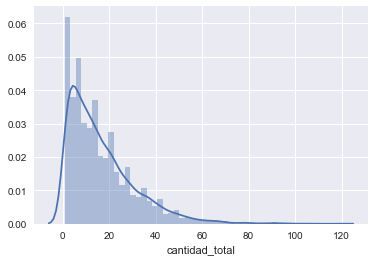

In [39]:
sns.distplot(df_grafico['cantidad_total']);

In [40]:
df_grafico['cantidad_total'].mean()

16.775757575757577

La mayor cantidad de compras son de cantidades bajas de productos, con un promedio de 16.7 productos por pedido

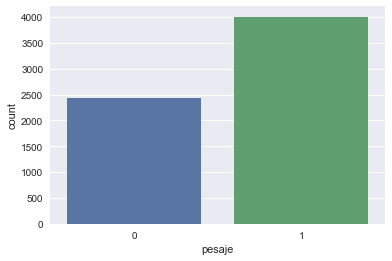

In [41]:
sns.countplot(data=df_grafico, x='pesaje');

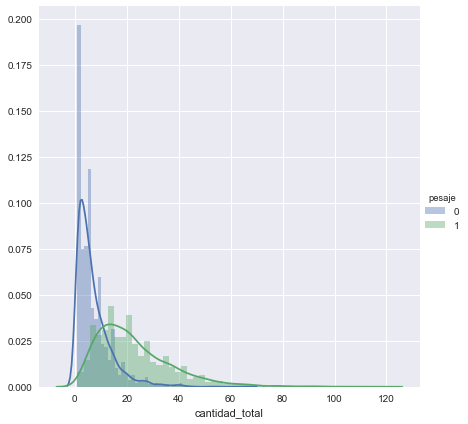

In [42]:
plt.rcParams['figure.figsize'] = 11.7,8.27
g = sns.FacetGrid(df_grafico, hue="pesaje",height= 6 )
g = g.map(sns.distplot, "cantidad_total")
g.add_legend();

In [43]:
print("Promedio de productos en ordenes sin productos que deban ser pesados = " +str(df_grafico.query("pesaje==0")['cantidad_total'].mean()))
print("Promedio de productos en ordenes con productos que deban ser pesados = " +str(df_grafico.query("pesaje==1")['cantidad_total'].mean()))

Promedio de productos en ordenes sin productos que deban ser pesados = 7.0930041152263374
Promedio de productos en ordenes con productos que deban ser pesados = 22.650686641697877


El gráfico ademas nos muestra que aquellas compras que tienen productos que se deben pesar, tienen una distribución diferente a aquellos en los que no se pide ningun producto de pesaje, siendo su promedio mayor en aquellos que deben ser pesados

### Relacion con el tiempo de entrega

In [44]:
df_grafico['tiempo_ajustado'] = pd.to_numeric(df.total_minutes.str.replace('.',''))/1000000

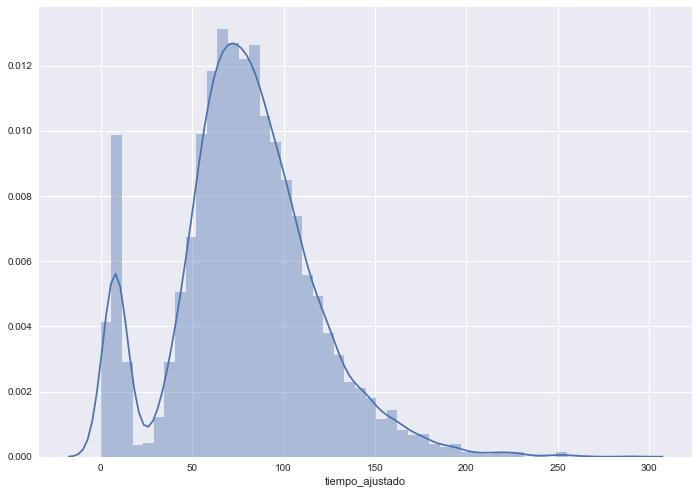

In [45]:
sns.distplot(df_grafico.tiempo_ajustado);

Es necesario revisar ese peak en los valores más bajos, ya que se puede deber a una mala codificación

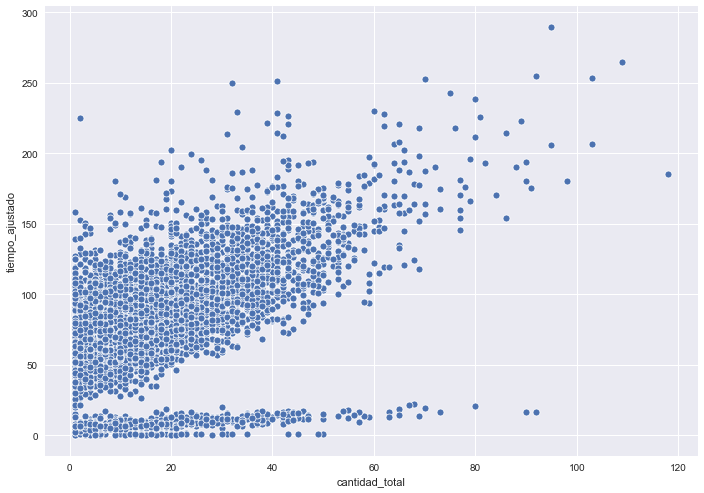

In [46]:
sns.scatterplot(data=df_grafico, x='cantidad_total', y='tiempo_ajustado');

El gráfico muestra evidencia para apoyar nuestra hipótesis, ya que se ve una correlación positiva entre la cantidad total de productos con el tiempo de entrega.

## Rating repartidor

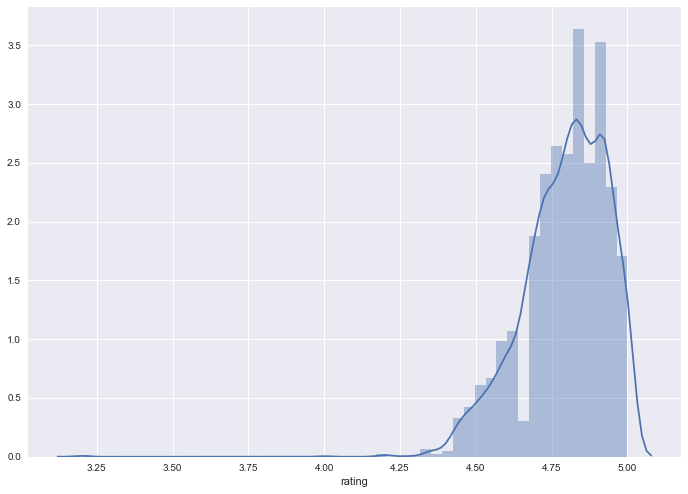

In [47]:
sns.distplot(df_grafico.rating);

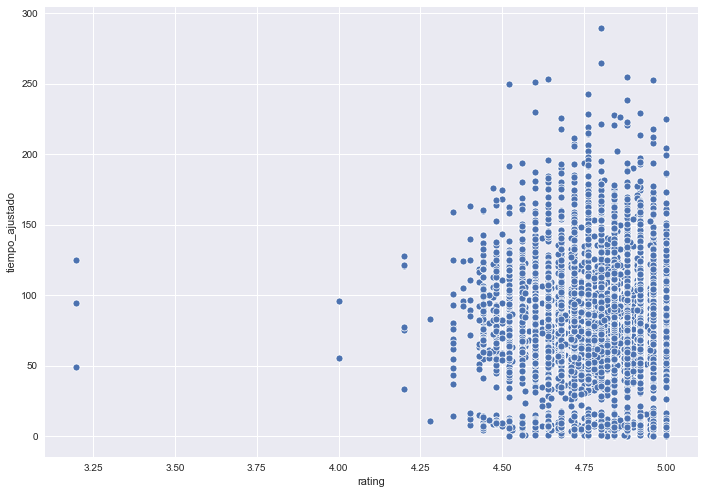

In [48]:
sns.scatterplot(data=df_grafico, x='rating', y='tiempo_ajustado');

En el caso del "Rating" del repartidor, de momento el gráfico no nos permite saber si es influyente en el tiempo de entrega, sobre todo por el hecho de que la distribución de las calificaciones es muy acotada entre 4.50 y 5

## Hora / Dia de la semana

### Hora

In [50]:
time = pd.DataFrame(df.actual_time.str.split(':', expand=True))
time.columns = ('hora','minuto','segundos')

In [51]:
df_grafico['hora'] = pd.to_numeric(time['hora'])

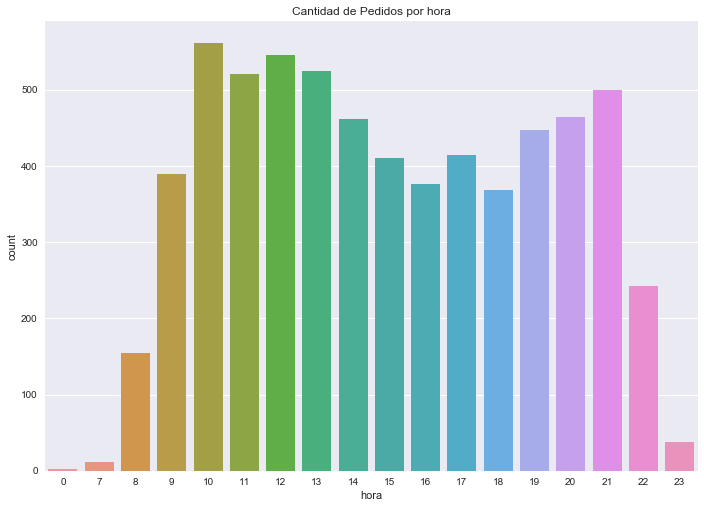

In [52]:
sns.countplot(data=df_grafico, x='hora',).set_title('Cantidad de Pedidos por hora');

La Mayor cantidad de pedidos se concentra entre 10 y 13, cayendo hasta retomar desde las 19 a las 21 hrs

In [56]:
df_grafico.groupby('hora').mean()['tiempo_ajustado']

hora
0      41.912408
7      45.957083
8      68.670544
9      83.771210
10     77.974623
11     79.263920
12     78.948382
13     79.870315
14     79.562786
15     78.623130
16     76.158499
17     73.019546
18     78.797715
19     80.943705
20     77.165613
21     81.815676
22     87.083190
23    103.121120
Name: tiempo_ajustado, dtype: float64

Text(0.5, 1.0, 'Hora vs Tiempo de entrega')

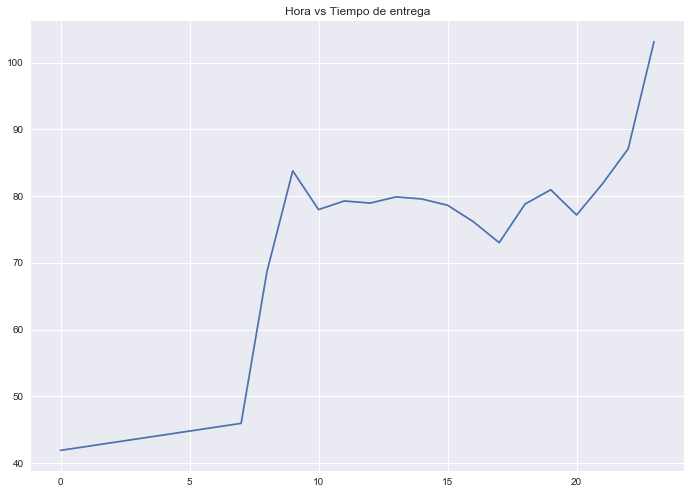

In [57]:
plt.plot(df_grafico.groupby('hora').mean()['tiempo_ajustado'])
plt.title('Hora vs Tiempo de entrega')

Revisando las horas, notamos que a las 9 hay un peak, al igual que a las 19 horas y luego pasado las 21 hrs

### Dia de la semana

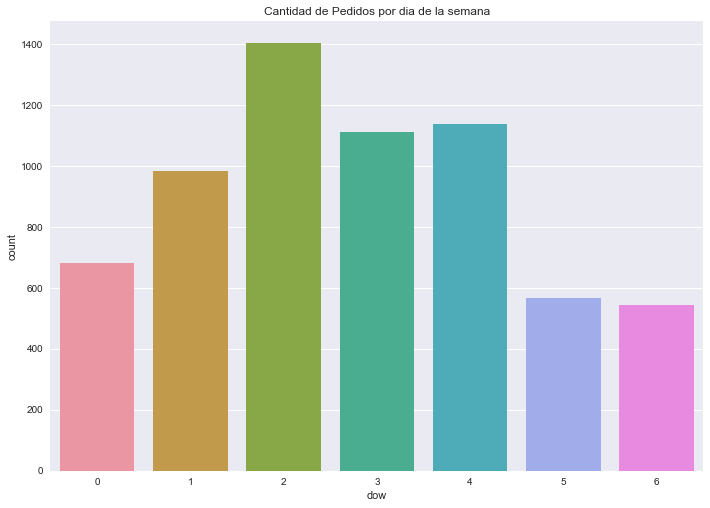

In [59]:
sns.countplot(data=df_grafico, x='dow',).set_title('Cantidad de Pedidos por dia de la semana');

De Lunes a jueves se concentra la mayor cantidad de pedidos, siendo viernes a domingo los que tienen menos edidos

In [60]:
df_grafico.groupby('dow').mean()['tiempo_ajustado']

dow
0    73.725803
1    81.178477
2    82.938702
3    81.439807
4    76.947051
5    76.535917
6    74.494866
Name: tiempo_ajustado, dtype: float64

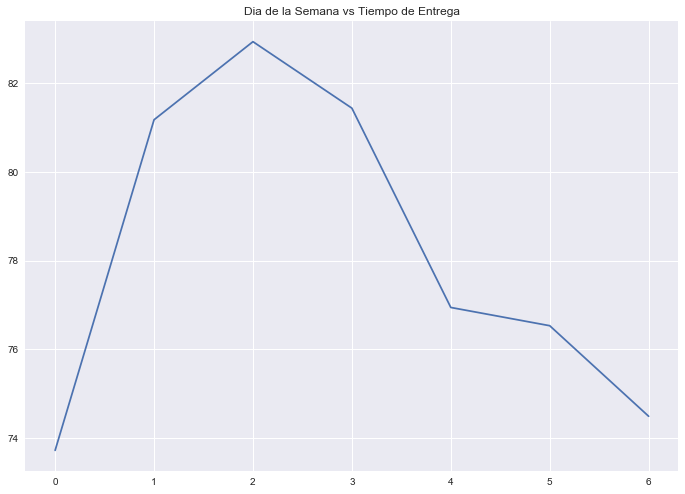

In [61]:
plt.plot(df_grafico.groupby('dow').mean()['tiempo_ajustado'])
plt.title('Dia de la Semana vs Tiempo de Entrega');

El tiempo de entrega es consistente con la cantidad de pedidos de cada día, excepto en el dia jueves, donde es menor en promedio que la cantidad de pedidos del mismo día

### Dia y Fecha

In [62]:
table = pd.pivot_table(df_grafico, values='tiempo_ajustado', index=['hora'], columns=['dow'], aggfunc=np.mean)

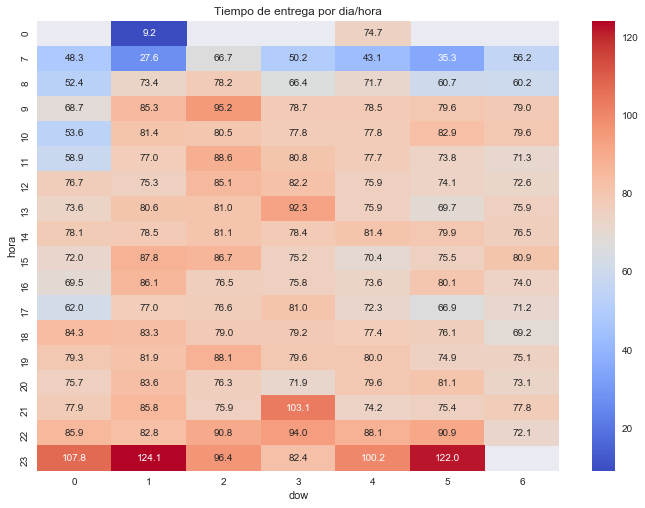

In [63]:
sns.heatmap(table,annot=True, cmap='coolwarm', fmt=".1f").set_title("Tiempo de entrega por dia/hora");

Notamos que diferentes dias tienen diferentes peaks de tiempo de demora, por ejemplo, los dias lunes hay grandes tiempos de entrega entre 15 y 16, y luego entre 18 y 22. Por otro lado, el dia martes tiene altos tiempos de entrega duante la mañana. El dia miercoles a las 21 hrs tiene untiempode espera superlativamente mayor al resto de los dias.
